In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
#importing libraries and reading data
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn  as sns
from sklearn.preprocessing import scale
pal = sns.color_palette()
pd.options.display.max_colwidth = 100

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
embeddings                    0.0MB
train.csv                     124.21MB
sample_submission.csv         1.3MB
test.csv                      5.24MB


In [3]:
# final submission format
df_sample = pd.read_csv('../input/sample_submission.csv')
df_sample.head()

,qid,prediction
0,00014894849d00ba98a9,0
1,000156468431f09b3cae,0
2,000227734433360e1aae,0
3,0005e06fbe3045bd2a92,0
4,00068a0f7f41f50fc399,0


In [4]:
# reading trainng data
df_train = pd.read_csv('../input/train.csv')
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [5]:
df_train.isnull().values.any()

False

In [10]:
df_test = pd.read_csv('../input/test.csv')
df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range....
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $200-300?
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario that’s impossible to happen in the link below? It sho...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [11]:
df_test.isnull().values.any()

False

In [12]:
#basic data info
print('Total number of question for training: {}'.format(len(df_train)))
print('Insincere questions: {}%'.format(round(df_train['target'].mean()*100, 2)))
print(df_train.dtypes)
print(df_train['target'].describe())
qids = pd.Series(df_train['qid'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))

insincere = df_train.loc[df_train.target == 1, 'target'].count()
sincere = df_train.loc[df_train.target == 0, 'target'].count()
print("Total number of insincere questions: ", insincere)
print("Total number of sincere questions: ", sincere)


Total number of question for training: 1306122
Insincere questions: 6.19%
qid              object
question_text    object
target            int64
dtype: object
count    1.306122e+06
mean     6.187018e-02
std      2.409197e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64
Total number of questions in the training data: 1306122
Total number of insincere questions:  80810
Total number of sincere questions:  1225312


In [13]:
#sample question
df_train.question_text[5]

'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?'

In [14]:
#reading test data
df_test = pd.read_csv('../input/test.csv')
df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range....
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $200-300?
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario that’s impossible to happen in the link below? It sho...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [15]:
df_test.isnull().values.any()

False

In [16]:
print('Total number of questions for testing: {}'.format(len(df_test)))

Total number of questions for testing: 56370


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-train 70.68 std-train 38.78 mean-test 70.46 std-test 38.73 max-train 1017.00 max-test 588.00


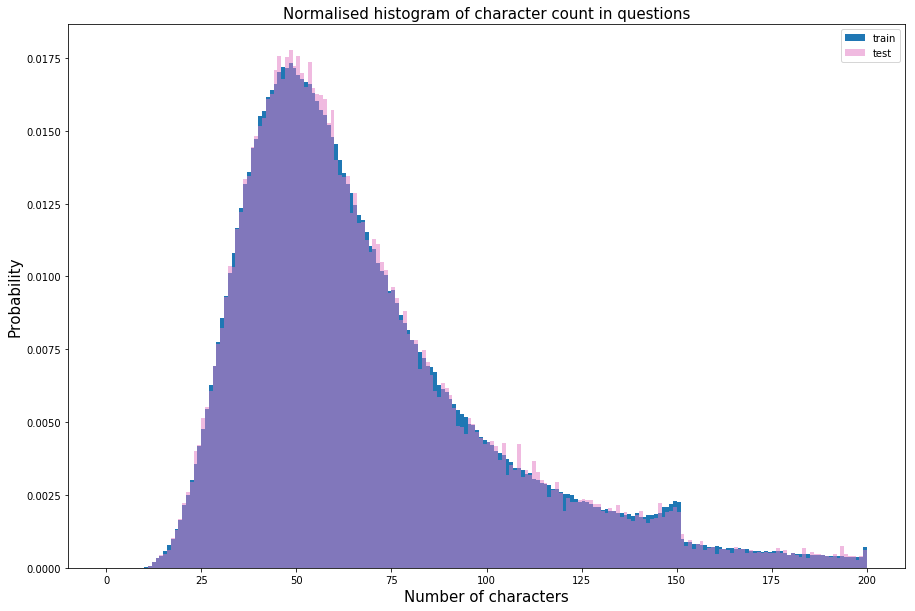

In [17]:
# train vs test char count
train_qs = pd.Series(df_train['question_text'].tolist()).astype(str)
test_qs = pd.Series(df_test['question_text'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[0], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[6], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-train 12.80 std-train 7.05 mean-test 12.75 std-test 7.01 max-train 122.00 max-test 87.00


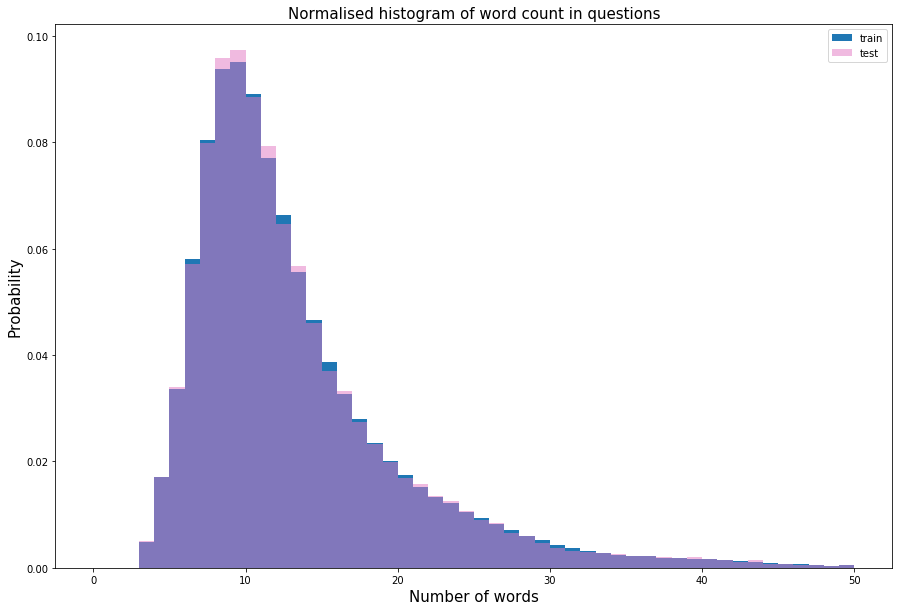

In [18]:
#train vs test word count
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[0], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[6], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

In [19]:
sincere_qsa = df_train.loc[df_train['target'] == 0]
print(sincere_qsa.head())
insincere_qsa = df_train.loc[df_train['target'] == 1]


                    qid  ...   target
0  00002165364db923c7e6  ...        0
1  000032939017120e6e44  ...        0
2  0000412ca6e4628ce2cf  ...        0
3  000042bf85aa498cd78e  ...        0
4  0000455dfa3e01eae3af  ...        0

[5 rows x 3 columns]


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-sincere 68.87 std-sincere 36.74 mean-insincere 98.06 std-insincere 55.19 max-sincere 752.00 max-insincere 1017.00


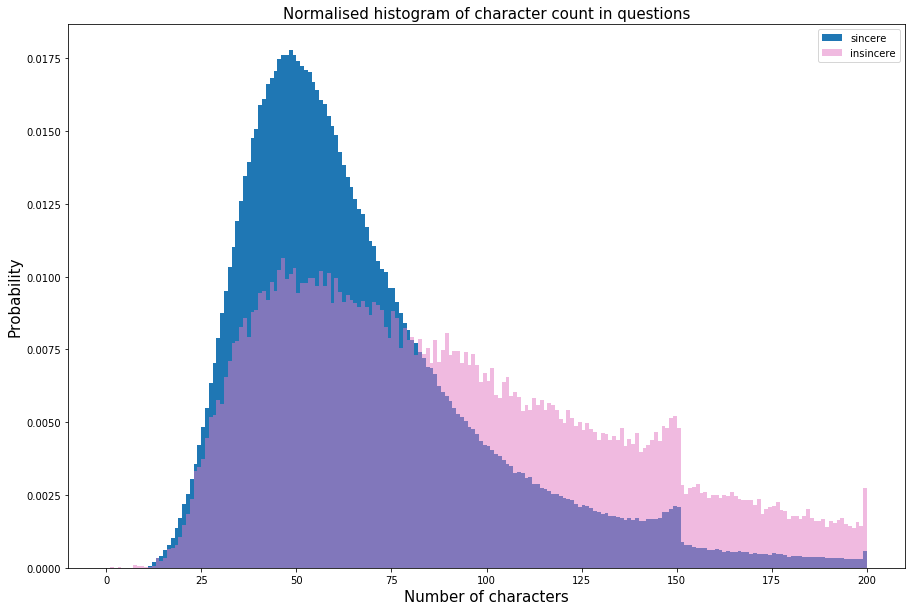

In [20]:
# sincere vs insincere char count
sincere_qsab = pd.Series(sincere_qsa['question_text'].tolist()).astype(str)
insincere_qsab = pd.Series(insincere_qsa['question_text'].tolist()).astype(str)

dist_sincere = sincere_qsab.apply(len)
dist_insincere = insincere_qsab.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_sincere, bins=200, range=[0, 200], color=pal[0], normed=True, label='sincere')
plt.hist(dist_insincere, bins=200, range=[0, 200], color=pal[6], normed=True, alpha=0.5, label='insincere')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-sincere {:.2f} std-sincere {:.2f} mean-insincere {:.2f} std-insincere {:.2f} max-sincere {:.2f} max-insincere {:.2f}'.format(dist_sincere.mean(), 
                          dist_sincere.std(), dist_insincere.mean(), dist_insincere.std(), dist_sincere.max(), dist_insincere.max()))

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-sincere 12.51 std-sincere 6.75 mean-insincere 17.28 std-insincere 9.57 max-sincere 122.00 max-insincere 64.00


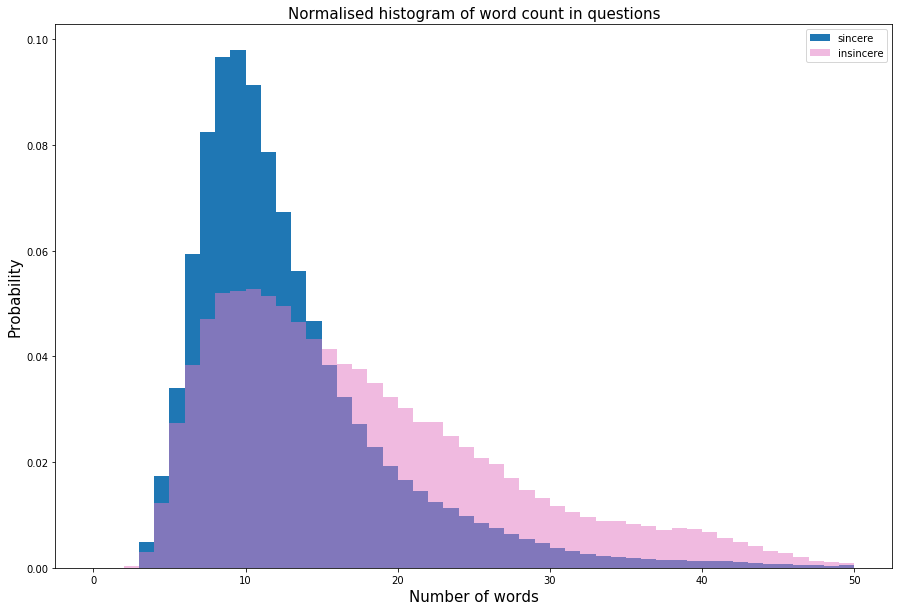

In [21]:
#sincere vs insincere word count
dist_sincere = sincere_qsab.apply(lambda x: len(x.split(' ')))
dist_insincere = insincere_qsab.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_sincere, bins=50, range=[0, 50], color=pal[0], normed=True, label='sincere')
plt.hist(dist_insincere, bins=50, range=[0, 50], color=pal[6], normed=True, alpha=0.5, label='insincere')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-sincere {:.2f} std-sincere {:.2f} mean-insincere {:.2f} std-insincere {:.2f} max-sincere {:.2f} max-insincere {:.2f}'.format(dist_sincere.mean(), 
                          dist_sincere.std(), dist_insincere.mean(), dist_insincere.std(), dist_sincere.max(), dist_insincere.max()))

# Trying average length, stopwords, word cloud

In [22]:
# using df_train_vis for all preprcessing
df_train_vis = df_train
#print(df_train_vis)
def avg_word_len(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df_train_vis['avg_word_length'] = df_train_vis['question_text'].apply(lambda x: avg_word_len(x))
df_train_vis[['question_text','avg_word_length']].head()

,question_text,avg_word_length
0,How did Quebec nationalists see their province as a nation in the 1960s?,4.615385
1,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",4.125000
2,Why does velocity affect time? Does velocity affect space geometry?,5.800000
3,How did Otto von Guericke used the Magdeburg hemispheres?,5.444444
4,Can I convert montra helicon D to a mountain bike by just changing the tyres?,4.200000


In [23]:
#counting stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_train_vis['stopwords'] = df_train_vis['question_text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_train_vis[['question_text','stopwords']].head()

,question_text,stopwords
0,How did Quebec nationalists see their province as a nation in the 1960s?,6
1,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",8
2,Why does velocity affect time? Does velocity affect space geometry?,1
3,How did Otto von Guericke used the Magdeburg hemispheres?,2
4,Can I convert montra helicon D to a mountain bike by just changing the tyres?,5


In [30]:
# converting to lowercase
df_train_vis['question_text'] = df_train_vis['question_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_train_vis[['qid', 'question_text', 'target']].head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province as a nation in the 1960s,0
1,000032939017120e6e44,do you have an adopted dog how would you encourage people to adopt and not shop,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity affect space geometry,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg hemispheres,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain bike by just changing the tyres,0


In [ ]:
#removing punctuation
df_train_vis['question_text'] = df_train_vis['question_text'].str.replace('[^\w\s]','')
df_train_vis.head()


In [31]:
#removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df_train_vis['question_text'] = df_train_vis['question_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_train_vis['question_text'].head()

0          quebec nationalists see province nation 1960s
1          adopted dog would encourage people adopt shop
2    velocity affect time velocity affect space geometry
3           otto von guericke used magdeburg hemispheres
4    convert montra helicon mountain bike changing tyres
Name: question_text, dtype: object

In [36]:
#spelling correction,do we need this, check question 4
# DO NOT NEED THIS


from textblob import TextBlob
df_train_vis['question_text'][:5].apply(lambda x: str(TextBlob(x).correct()))
df_train_vis[['qid', 'question_text', 'target']].head()

,qid,question_text,target
0,00002165364db923c7e6,quebec nationalist see province nation 1960s,0
1,000032939017120e6e44,adopted dog would encourage people adopt shop,0
2,0000412ca6e4628ce2cf,velocity affect time velocity affect space geometry,0
3,000042bf85aa498cd78e,otto von guericke used magdeburg hemisphere,0
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing tyre,0


In [33]:
#stemming, do we need this, check question 2
from nltk.stem import PorterStemmer
st = PorterStemmer()
df_train_vis['question_text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0         quebec nationalist see provinc nation 1960
1          adopt dog would encourag peopl adopt shop
2      veloc affect time veloc affect space geometri
3           otto von guerick use magdeburg hemispher
4    convert montra helicon mountain bike chang tyre
Name: question_text, dtype: object

In [35]:
#stemming++, lemmaatisation, do we need this either?
from textblob import Word
df_train_vis['question_text'] = df_train_vis['question_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_train_vis[['qid', 'question_text', 'target']].head()

,qid,question_text,target
0,00002165364db923c7e6,quebec nationalist see province nation 1960s,0
1,000032939017120e6e44,adopted dog would encourage people adopt shop,0
2,0000412ca6e4628ce2cf,velocity affect time velocity affect space geometry,0
3,000042bf85aa498cd78e,otto von guericke used magdeburg hemisphere,0
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing tyre,0


In [40]:
df_train_vis.tail()

,qid,question_text,target,avg_word_length,stopwords
1306117,ffffcc4e2331aaf1e41e,technical skill need computer science undergrad c c,0,4.529412,8
1306118,ffffd431801e5a2f4861,m ece good job prospect usa like india job present,0,3.842105,7
1306119,ffffd48fb36b63db010c,foam insulation toxic,0,5.500000,0
1306120,ffffec519fa37cf60c78,one start research project based biochemistry ug level,0,4.538462,4
1306121,ffffed09fedb5088744a,win battle wolverine puma,0,3.818182,6


In [41]:
# using new_df_train for all training
new_df_train = df_train_vis
names = new_df_train.columns.values 
print(names)

['qid' 'question_text' 'target' 'avg_word_length' 'stopwords']


In [42]:
quora_df_train = new_df_train.drop('avg_word_length', 1)

In [43]:

quoradf_train = quora_df_train.drop('stopwords', 1)

In [44]:
names = quora_df_train.columns.values 
print(names)
columnss = quoradf_train.columns.values 
print(columnss)

['qid' 'question_text' 'target' 'stopwords']
['qid' 'question_text' 'target']


# insincere df

In [45]:
insincere_df = quoradf_train.loc[df_train['target'] == 1]
print("total number of insincere qs: ", len(insincere_df))
print(insincere_df.tail())

total number of insincere qs:  80810
                          qid  ...   target
1306093  fffeba722d9b371bd1b9  ...        1
1306094  fffee269360dd0d3947a  ...        1
1306099  ffff0e4ea1bb6e16feec  ...        1
1306103  ffff3f0a2449ffe4b9ff  ...        1
1306112  ffffa5b0fa76431c063f  ...        1

[5 rows x 3 columns]


In [46]:
#dropping top n rows from insincere_df, leaving 500 qs
insincere_df.drop(insincere_df.head(78010).index,inplace=True)
print(len(insincere_df))

2800


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


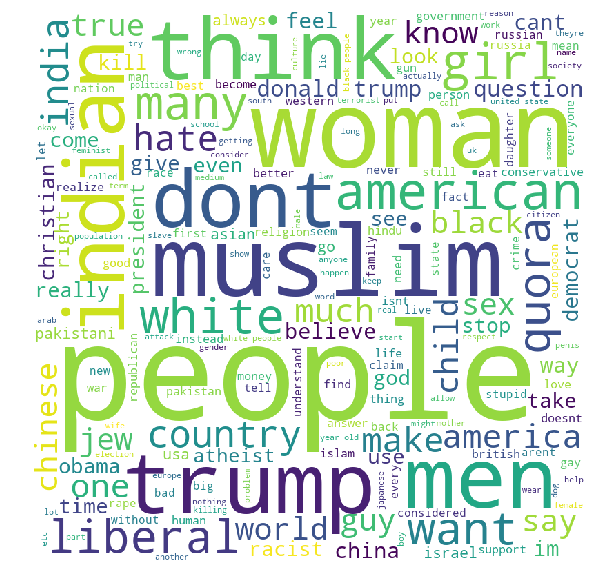

In [47]:
#word cloud for insincere qs
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
q_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in insincere_df['question_text']: 
      
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split() 
          
    for words in tokens: 
        q_words = q_words + words + ' '
  

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(q_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Sincere

In [48]:
sincere_df = quoradf_train.loc[df_train['target'] == 0]
print("total number of sincere qs: ", len(sincere_df))
print(sincere_df.tail())

total number of sincere qs:  1225312
                          qid  ...   target
1306117  ffffcc4e2331aaf1e41e  ...        0
1306118  ffffd431801e5a2f4861  ...        0
1306119  ffffd48fb36b63db010c  ...        0
1306120  ffffec519fa37cf60c78  ...        0
1306121  ffffed09fedb5088744a  ...        0

[5 rows x 3 columns]


In [49]:
#dropping top n rows from sincere_df, leaving 500 qs
sincere_df.drop(sincere_df.head(1221212).index,inplace=True)
print(len(sincere_df))

4100


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


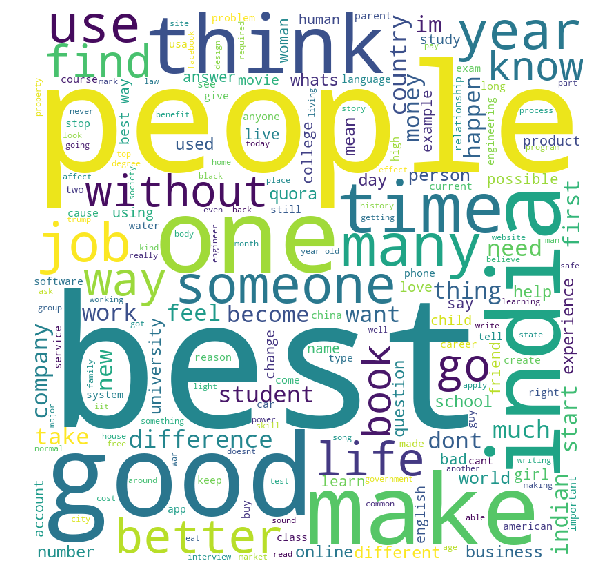

In [50]:
#word cloud for sincere qs
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
q_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in sincere_df['question_text']: 
      
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split() 
          
    for words in tokens: 
        q_words = q_words + words + ' '
  

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(q_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [51]:
insincere_df = quoradf_train.loc[df_train['target'] == 1]

In [52]:
insincere1 = insincere_df
insincere2 = insincere_df
insincere3 = insincere_df
insincere4 = insincere_df
insincere5 = insincere_df

In [53]:
fake_insincere = pd.concat([insincere1, insincere2, insincere3, insincere4, insincere5, insincere1, insincere2, insincere3, insincere4, insincere5, insincere1, insincere2, insincere3, insincere4, insincere5], ignore_index=True)

In [54]:
len(fake_insincere)

1212150

Combining fake_insincere and sincere for balanced data

In [55]:
sincere_df = quoradf_train.loc[df_train['target'] == 0]

In [56]:
df_quora = pd.concat([sincere_df, fake_insincere], ignore_index=True)

In [57]:
len(df_quora)

2437462

In [86]:
#basic data info
print('Total number of question for training: {}'.format(len(df_quora)))
print('Insincere questions: {}%'.format(round(df_quora['target'].mean()*100, 2)))

#print(df_quora.dtypes)
#print(df_quora['target'].describe())
qids = pd.Series(df_quora['qid'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))

insincere = df_quora.loc[df_quora.target == 1, 'target'].count()
sincere = df_quora.loc[df_quora.target == 0, 'target'].count()
print("Total number of insincere questions: ", insincere)
print("Total number of sincere questions: ", sincere)

Total number of question for training: 2437462
Insincere questions: 49.73%
Total number of questions in the training data: 1306122
Total number of insincere questions:  1212150
Total number of sincere questions:  1225312
